# DA5401 : Data Analytics Lab End-Semester Data Challenge

Metric learning to study the fitness of a test conversation against an evaluation metric while testing conversational AI agents

Part A : Data Loading and Preprocessing

In [1]:
!unzip /content/da5401-2025-data-challenge.zip

Archive:  /content/da5401-2025-data-challenge.zip
  inflating: metric_name_embeddings.npy  
  inflating: metric_names.json       
  inflating: sample_submission.csv   
  inflating: test_data.json          
  inflating: train_data.json         


Installing Sentence Transformer Model to generate the prompt and response embeddings

In [2]:
!pip install sentence-transformers

In [5]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import lightgbm as lgb
from lightgbm import LGBMRegressor
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.metrics import root_mean_squared_error, accuracy_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sentence_transformers import SentenceTransformer
from tqdm import tqdm
from collections import Counter

In [6]:
encoder=SentenceTransformer("paraphrase-multilingual-mpnet-base-v2")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/723 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/402 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Loading metric embeddings

In [8]:
with open('/content/metric_names.json', 'r') as f:
  metric_names=json.load(f)
metric_embeddings=np.load('/content/metric_name_embeddings_new.npy')
metric_to_emb={name:emb for name, emb in zip (metric_names, metric_embeddings)}

embedding_dim=metric_embeddings.shape[1]
default_embedding=np.zeros(embedding_dim)

Loading the training data and generating the embeddings for prompt-response and system-prompt pairs

In [9]:
train_json_file='/content/train_data.json'
with open(train_json_file, 'r', encoding='utf-8') as f:
    train_data = json.load(f)

df=pd.DataFrame(train_data)
train_df=df.copy()

In [10]:
print(train_df['system_prompt'].isna().sum())

1549


There are None/NaN values in the system prompt column, which indicates that it cannot be provided as input directly to the model.

The function defined below provides the embeddings for the input dataframe

In [11]:
def generate_embeddings(dataframe):
  dataframe['system_prompt']=dataframe['system_prompt'].fillna('').tolist() # Converts NaN values to empty strings
  dataframe['combined_text']="Prompt : " + dataframe['user_prompt'] + "\nResponse : " + dataframe['response'] + "\nSystem : " + dataframe['system_prompt']
  dataframe['metric_embedding']=dataframe['metric_name'].apply(
    lambda x: metric_to_emb.get(x, default_embedding))
  text_embeddings=encoder.encode(dataframe['combined_text'].tolist(), batch_size=32, show_progress_bar=True)
  dataframe['text_embedding']=list(text_embeddings)
  return dataframe

In [12]:
train_df=generate_embeddings(train_df)

Batches:   0%|          | 0/157 [00:00<?, ?it/s]

In [13]:
metric_emb=np.array(train_df['metric_embedding'].tolist())
text_emb=np.array(train_df['text_embedding'].tolist())
diff=np.abs(metric_emb)
prod=metric_emb*text_emb
X=np.concatenate([metric_emb, text_emb, diff, prod], axis=1)
y=train_df['score'].values

Including element-wise interactions (absolute difference and product) captures how similar or aligned the two embeddings are, which simple concatenation cannot represent. These interaction features help the model learn relationships between pairs of embeddings (e.g., agreement, magnitude mismatch), making it easier for even simple regression models to pick up semantic similarity pattern

In [14]:
print('No. of unique values in y = ', np.unique(y).size)

No. of unique values in y =  12


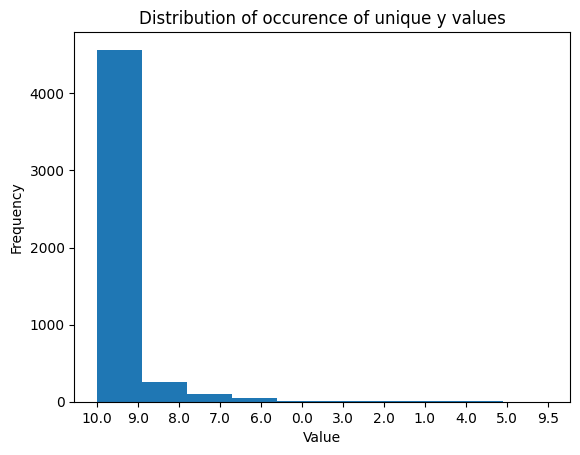

In [15]:
dist=Counter(y)

plt.hist(y)
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.title("Distribution of occurence of unique y values")
plt.show()

The above plot indicates that the data is highly skewed. The metric scores for most of the training data points is 10. A regression model trained on skewed training data can overfit and lead to bad testing results. Hence, it is important to resample the data to make the distribution of scores more uniform

Part B : Resampling Using SMOTE

Found a single sample with score '5' at index 2533.
Changing its label to '4' to enable SMOTE.

New smallest class now has 4 samples. Setting k_neighbors for SMOTE to 3.
Original data shape: (5000, 3072)
Resampled data shape (using SMOTE): (31230, 3072)


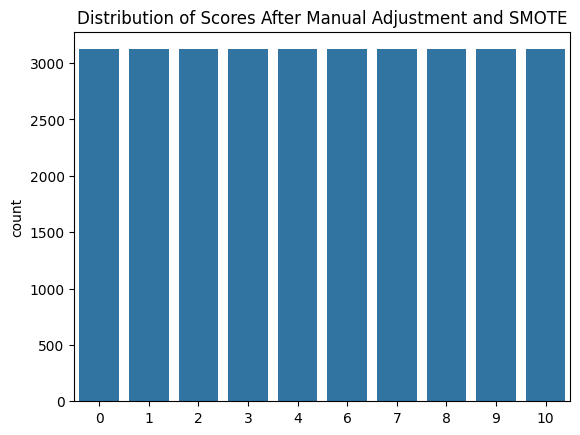

In [16]:
y_discrete=np.round(pd.to_numeric(y, errors='coerce')).astype(int)
value_counts=pd.Series(y_discrete).value_counts()
singleton_class = value_counts[value_counts == 1].index

if not singleton_class.empty:
  singleton_value=singleton_class[0]
  singleton_index=np.where(y_discrete == singleton_value)[0][0]
  new_value=singleton_value-1 if singleton_value>0 else singleton_value+1
  print(f"Found a single sample with score '{singleton_value}' at index {singleton_index}.")
  print(f"Changing its label to '{new_value}' to enable SMOTE.")
  y_discrete[singleton_index]=new_value
else:
  print("No singleton classes found.")

min_class_count=pd.Series(y_discrete).value_counts().min()
k_neighbors_for_smote=max(1, min_class_count - 1)

print(f"\nNew smallest class now has {min_class_count} samples. Setting k_neighbors for SMOTE to {k_neighbors_for_smote}.")

smote_sampler = SMOTE(random_state=42, k_neighbors=k_neighbors_for_smote)

print(f"Original data shape: {X.shape}")
X_resampled, y_resampled = smote_sampler.fit_resample(X, y_discrete)
print(f"Resampled data shape (using SMOTE): {X_resampled.shape}")

# Visualizing the new distribution
plt.figure()
sns.countplot(x=y_resampled)
plt.title("Distribution of Scores After Manual Adjustment and SMOTE")
plt.show()

SMOTE increases the number of data points but also ensures that the distribution of the scores is uniform

In [17]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

Part C : Metric Evaluation Models

The model starts with simple Linear Regression and further builds upto the Boosting algorithm. The models are trained on original data and the data resampled with SMOTE and a comparative analysis is done to choose the best possibility

Sub Part A : Training on original data

1. Linear Regression

In [18]:
lr=LinearRegression()
lr.fit(X_train, y_train)
y_pred=lr.predict(X_val)
rmse=root_mean_squared_error(y_val, y_pred)
print(rmse)

1.1498345136642456


2. Ridge Regression with Cross Validation

In [19]:
ridge_model=RidgeCV()
ridge_model.fit(X_train, y_train)
y_pred_ridge=ridge_model.predict(X_val)
rmse_ridge=root_mean_squared_error(y_val, y_pred_ridge)
print(rmse_ridge)

0.9211753898808243


3. LightGBM

In [20]:
lgbm_reg=LGBMRegressor(
        objective='rmse', metric='rmse', n_estimators=2000, learning_rate=0.0005,num_leaves=15, lambda_l1=0.5, lambda_l2=0.7, feature_fraction=0.7,
        bagging_fraction=0.7, min_child_samples=50, bagging_freq=1,
        verbose=-1, n_jobs=-1, seed=42)
lgbm_reg.fit(X_train, y_train,
             eval_set=[(X_val, y_val)],
    eval_metric='rmse',
    callbacks=[
        lgb.early_stopping(100, verbose=True),
        lgb.log_evaluation(period=50)
    ])
y_pred_lgbm=lgbm_reg.predict(X_val)
rmse_lgbm=root_mean_squared_error(y_val, y_pred_lgbm)
print(rmse_lgbm)

Training until validation scores don't improve for 100 rounds
[50]	valid_0's rmse: 0.945475
[100]	valid_0's rmse: 0.943588
[150]	valid_0's rmse: 0.941839
[200]	valid_0's rmse: 0.940082
[250]	valid_0's rmse: 0.938495
[300]	valid_0's rmse: 0.936878
[350]	valid_0's rmse: 0.935419
[400]	valid_0's rmse: 0.934068
[450]	valid_0's rmse: 0.932671
[500]	valid_0's rmse: 0.931399
[550]	valid_0's rmse: 0.930191
[600]	valid_0's rmse: 0.928997
[650]	valid_0's rmse: 0.927887
[700]	valid_0's rmse: 0.926799
[750]	valid_0's rmse: 0.925822
[800]	valid_0's rmse: 0.924767
[850]	valid_0's rmse: 0.923877
[900]	valid_0's rmse: 0.922996
[950]	valid_0's rmse: 0.922145
[1000]	valid_0's rmse: 0.921345
[1050]	valid_0's rmse: 0.920552
[1100]	valid_0's rmse: 0.919888
[1150]	valid_0's rmse: 0.919158
[1200]	valid_0's rmse: 0.918481
[1250]	valid_0's rmse: 0.917879
[1300]	valid_0's rmse: 0.91724
[1350]	valid_0's rmse: 0.916666
[1400]	valid_0's rmse: 0.916178
[1450]	valid_0's rmse: 0.91566
[1500]	valid_0's rmse: 0.915192


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


XG Boost Regression

In [21]:
xgb_model=xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=5)
xgb_model.fit(X_train, y_train)
y_pred_xgb=xgb_model.predict(X_val)
rmse_xgb=root_mean_squared_error(y_val, y_pred_xgb)
print(rmse_xgb)

0.9313530325889587


Training the same models on the resampled data and evaluating the Root Mean Squared Error (RMSE)

In [22]:
X_train_resampled, X_val_resampled, y_train_resampled, y_val_resampled = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)

1. Linear Regression

In [23]:
lr_smote=LinearRegression()
lr_smote.fit(X_train_resampled, y_train_resampled)
y_pred_smote=lr_smote.predict(X_val_resampled)
smote_rmse_linear=root_mean_squared_error(y_val_resampled, y_pred_smote)
print(smote_rmse_linear)

0.8317031860351562


2. Ridge Regression

In [24]:
ridge_model_smote=RidgeCV()
ridge_model_smote.fit(X_train_resampled, y_train_resampled)
y_pred_ridge_smote=ridge_model_smote.predict(X_val_resampled)
smote_rmse_ridge=root_mean_squared_error(y_val_resampled, y_pred_ridge_smote)
print(smote_rmse_ridge)

0.7769353447141925


3. LightGBM

In [25]:
lgbm_reg_smote=LGBMRegressor(
        objective='rmse', metric='rmse', n_estimators=2000, learning_rate=0.0005,num_leaves=15, lambda_l1=0.5, lambda_l2=0.7, feature_fraction=0.7,
        bagging_fraction=0.7, min_child_samples=50, bagging_freq=1,
        verbose=-1, n_jobs=-1, seed=42)
lgbm_reg_smote.fit(X_train_resampled, y_train_resampled,
             eval_set=[(X_val_resampled, y_val_resampled)],
    eval_metric='rmse',
    callbacks=[
        lgb.early_stopping(100, verbose=True),
        lgb.log_evaluation(period=50)
    ])
y_pred_lgbm_smote=lgbm_reg_smote.predict(X_val_resampled)
smote_rmse_lgbm=root_mean_squared_error(y_val_resampled, y_pred_lgbm_smote)
print(smote_rmse_lgbm)

Training until validation scores don't improve for 100 rounds
[50]	valid_0's rmse: 3.2545
[100]	valid_0's rmse: 3.19405
[150]	valid_0's rmse: 3.13515
[200]	valid_0's rmse: 3.07773
[250]	valid_0's rmse: 3.02176
[300]	valid_0's rmse: 2.96717
[350]	valid_0's rmse: 2.91375
[400]	valid_0's rmse: 2.86147
[450]	valid_0's rmse: 2.8101
[500]	valid_0's rmse: 2.76011
[550]	valid_0's rmse: 2.71118
[600]	valid_0's rmse: 2.66356
[650]	valid_0's rmse: 2.61673
[700]	valid_0's rmse: 2.57072
[750]	valid_0's rmse: 2.52592
[800]	valid_0's rmse: 2.48217
[850]	valid_0's rmse: 2.4393
[900]	valid_0's rmse: 2.39723
[950]	valid_0's rmse: 2.35619
[1000]	valid_0's rmse: 2.31607
[1050]	valid_0's rmse: 2.27675
[1100]	valid_0's rmse: 2.23851
[1150]	valid_0's rmse: 2.20118
[1200]	valid_0's rmse: 2.16495
[1250]	valid_0's rmse: 2.12944
[1300]	valid_0's rmse: 2.09476
[1350]	valid_0's rmse: 2.0609
[1400]	valid_0's rmse: 2.02796
[1450]	valid_0's rmse: 1.99567
[1500]	valid_0's rmse: 1.96421
[1550]	valid_0's rmse: 1.93365
[

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


1.68910621339929


4. XG Boost Regression

In [26]:
xgb_model_smote=xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=5)
xgb_model_smote.fit(X_train_resampled, y_train_resampled)
y_pred_xgb_smote=xgb_model.predict(X_val_resampled)
smote_rmse_xgb=root_mean_squared_error(y_val_resampled, y_pred_xgb_smote)
print(smote_rmse_xgb)

4.126843452453613


Comparison of RMSE values

| Model               | RMSE (Original Data) | RMSE (SMOTE Data) |
|---------------------|-----------------------|--------------------|
| Linear Regression    |   1.14              |     0.83         |
| Ridge Regression     |   0.92              |     0.77         |
| LightGBM Regression  |   0.91              |     1.689        |
| XGBoost Regression   |   0.93              |     4.12         |


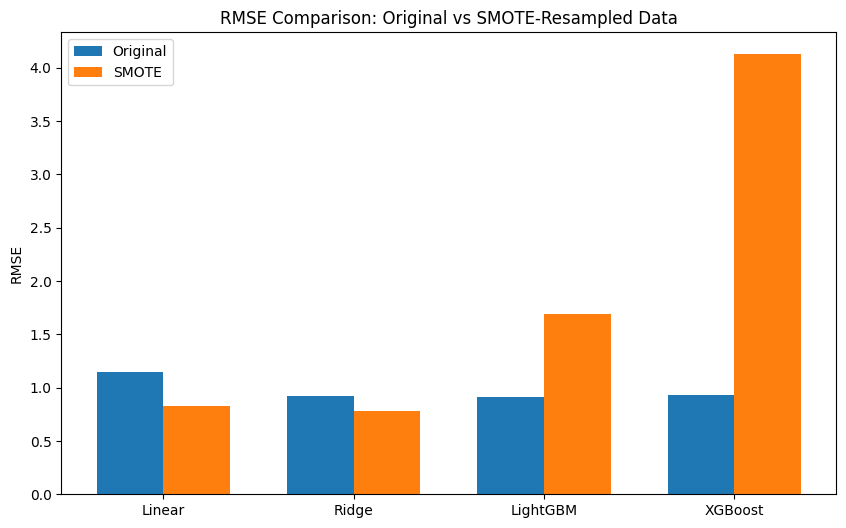

In [27]:
models = ["Linear", "Ridge", "LightGBM", "XGBoost"]
rmse_original = [rmse, rmse_ridge, rmse_lgbm, rmse_xgb]
rmse_smote = [smote_rmse_linear, smote_rmse_ridge, smote_rmse_lgbm, smote_rmse_xgb]

x = np.arange(len(models))
width = 0.35

plt.figure(figsize=(10, 6))

plt.bar(x - width/2, rmse_original, width, label="Original")
plt.bar(x + width/2, rmse_smote, width, label="SMOTE")

plt.xticks(x, models)
plt.ylabel("RMSE")
plt.title("RMSE Comparison: Original vs SMOTE-Resampled Data")
plt.legend()

plt.show()


Thus, it is observed that SMOTE resampling performs well on simple models - Linear and Ridge Regression, but provides significantly higher RMSE in case of more complicated models (LightGBM and XGBoost Regression)

Part D : Generating the scores on the test data

In [28]:
test_json_file='/content/test_data.json'
with open(test_json_file, 'r', encoding='utf-8') as f:
    test_data = json.load(f)

test_df=pd.DataFrame(test_data)

In [29]:
test_df=generate_embeddings(test_df)

Batches:   0%|          | 0/114 [00:00<?, ?it/s]

In [30]:
test_metric_emb=np.array(test_df['metric_embedding'].tolist())
test_text_emb=np.array(test_df['text_embedding'].tolist())
test_diff=np.abs(test_metric_emb-test_text_emb)
test_prod=test_metric_emb*test_text_emb

In [33]:
X_test=np.concatenate([test_metric_emb, test_text_emb, test_diff, test_prod], axis=1)
y_test=ridge_model_smote.predict(X_test)
y_test_rounded=np.rint(y_test)

In [34]:
ids=np.arange(len(y_test))
pred_df=pd.DataFrame({'id':ids+1, 'score': y_test_rounded})
pred_df.to_csv('/content/da5401_submission.csv', index=False)

Based on the submissions, the Ridge Model provided the best results. Hence, this model can be chosen to evaluate the performance of the AI model. The performance can be further improved using techniques such as experimenting with different transformer models for generating embeddings, hyperparameter tuning using Grid search, expanding to further complex models, and feature shuffling.